In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import mean_std_cross_val_scores, load_data
import os

In [31]:
# data_path = "data/"

# df = None
# for path in os.listdir(data_path):
#     df = pd.concat([df, load_data(f"data/{path}")])

In [32]:
# df.shape

In [33]:
df = load_data("data/Extended_Realistic_Training_Time_Dataset.csv")

In [6]:
df.head()

,CPU_Cores,RAM_GB,GPU_Available,GPU_VRAM_GB,Disk_Speed_MBps,Dataset_Size_MB,Num_Features,Model_Complexity,CV_Folds,Training_Time_Seconds
0,32,372.909091,1,16.653061,1931.313131,8080.867677,482,191.959596,7,71.535024
1,8,424.424242,1,42.122449,4703.030303,3636.445455,103,111.555556,5,215.686325
2,8,197.757576,1,30.367347,2129.292929,11717.213131,1148,39.191919,3,320.341791
3,32,285.333333,0,0.000000,3515.151515,1616.253535,571,103.515152,5,128.933086
4,64,342.000000,0,13.714286,1337.373737,2424.330303,482,27.131313,3,32.344779


In [7]:
df.isna().any().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CPU_Cores              100000 non-null  int64  
 1   RAM_GB                 100000 non-null  float64
 2   GPU_Available          100000 non-null  int64  
 3   GPU_VRAM_GB            100000 non-null  float64
 4   Disk_Speed_MBps        100000 non-null  float64
 5   Dataset_Size_MB        100000 non-null  float64
 6   Num_Features           100000 non-null  int64  
 7   Model_Complexity       100000 non-null  float64
 8   CV_Folds               100000 non-null  int64  
 9   Training_Time_Seconds  100000 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.6 MB


In [9]:
df.describe()

,CPU_Cores,RAM_GB,GPU_Available,GPU_VRAM_GB,Disk_Speed_MBps,Dataset_Size_MB,Num_Features,Model_Complexity,CV_Folds,Training_Time_Seconds
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,13.676680,256.746545,0.602290,23.961874,2552.070374,9996.577290,1005.178760,100.809877,6.498350,838.842159
std,17.900118,149.232913,0.489427,14.116411,1428.787162,5831.203597,575.510862,58.057008,2.291399,1124.798855
min,1.000000,2.000000,0.000000,0.000000,100.000000,0.100000,10.000000,1.000000,3.000000,8.477904
25%,4.000000,125.636364,0.000000,11.755102,1337.373737,4848.560606,505.000000,51.252525,4.000000,214.897014
50%,8.000000,259.575758,1.000000,23.510204,2525.252525,10101.059596,1007.000000,101.505051,7.000000,453.442676
75%,16.000000,388.363636,1.000000,36.244898,3812.121212,14949.520202,1505.000000,151.757576,9.000000,967.201201
max,128.000000,512.000000,1.000000,48.000000,5000.000000,20000.000000,1999.000000,200.000000,10.000000,13044.598555


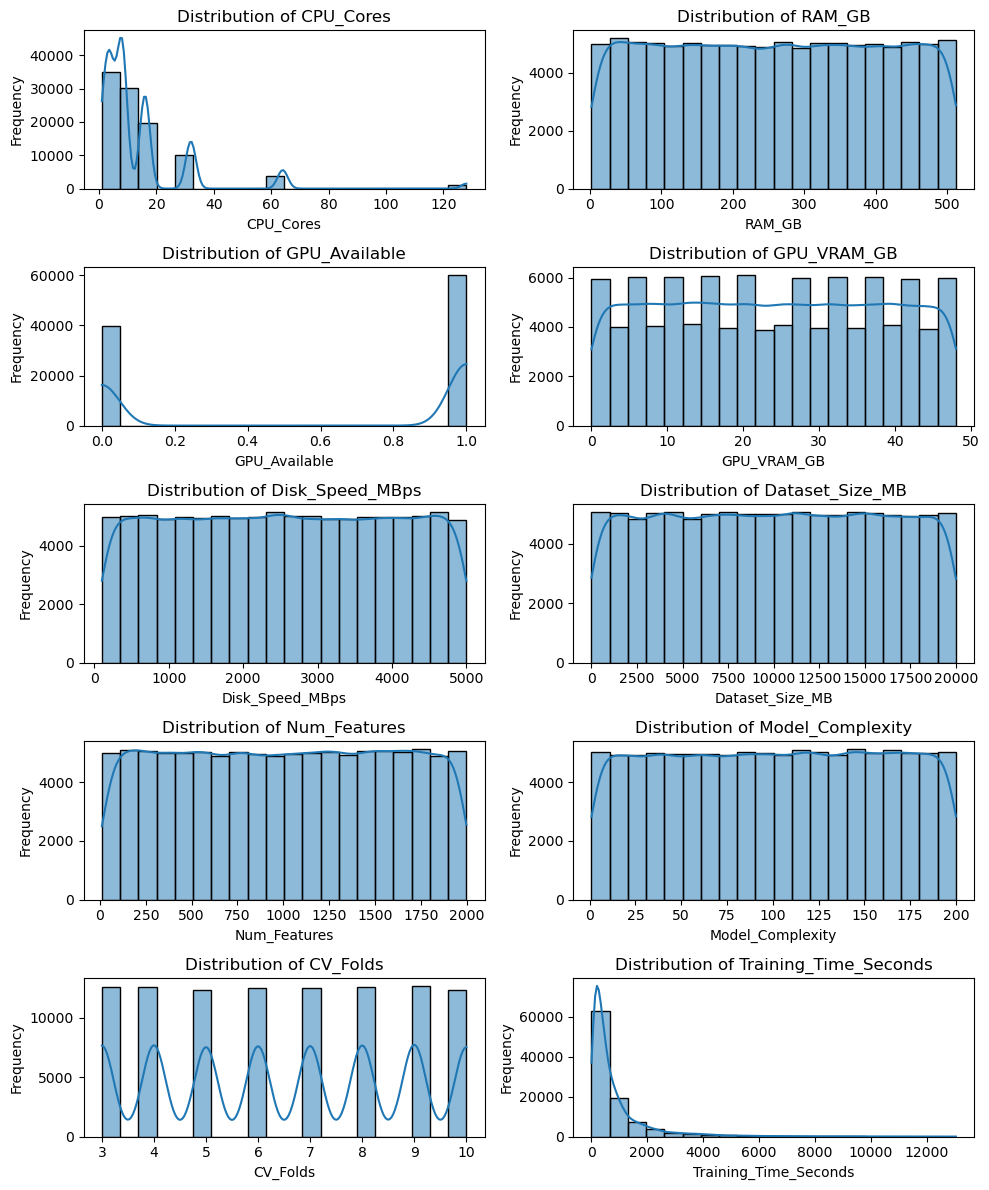

In [10]:
columns = df.columns

rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(10,12), tight_layout=True)
axes = axes.ravel()

for i, feature in enumerate(columns):
    sns.histplot(df[feature], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

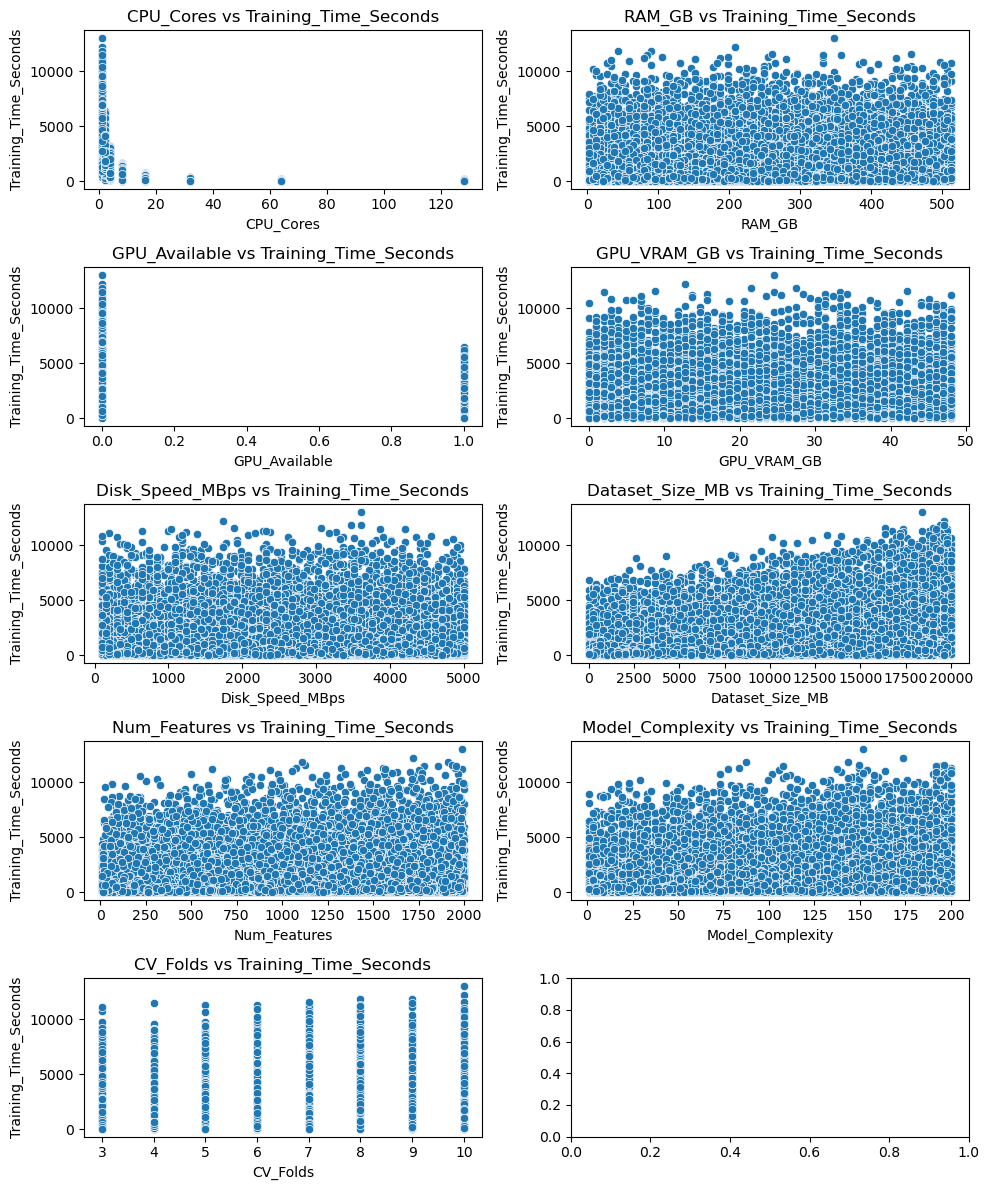

In [11]:
fig, axes = plt.subplots(rows, cols, figsize=(10,12), tight_layout=True)
axes = axes.ravel()

target = 'Training_Time_Seconds'

for i, feature in enumerate(columns):
    if feature != target:
        sns.scatterplot(df, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f"{feature} vs {target}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)



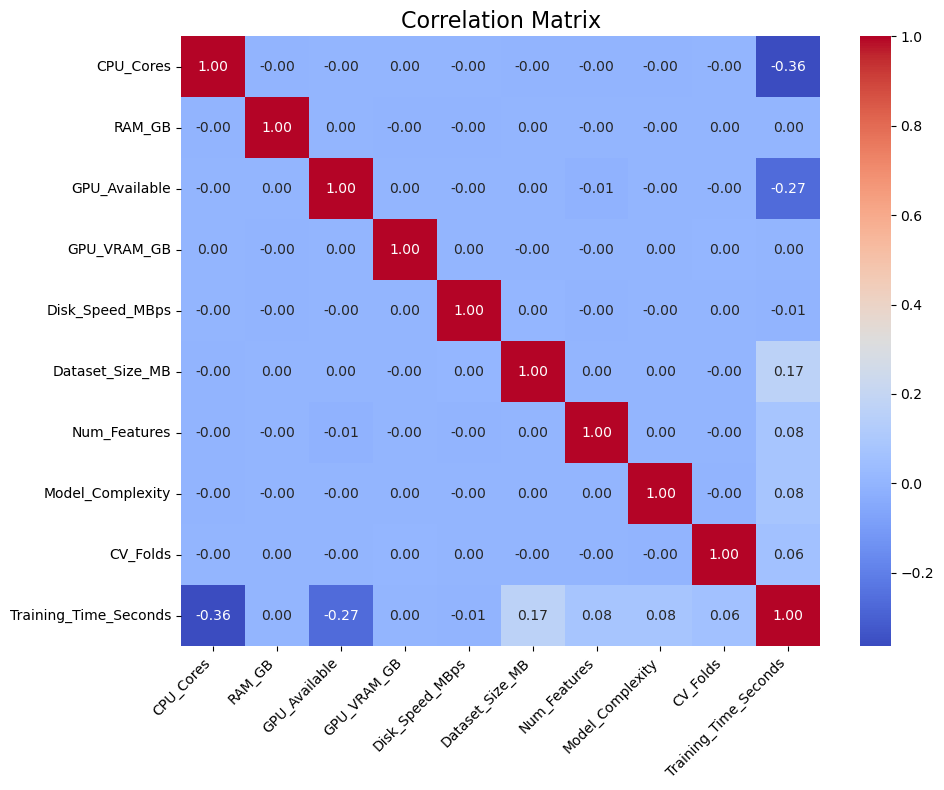

In [12]:
plt.figure(figsize=(10, 8))  
sns.heatmap(
    df.corr(), 
    annot=True, 
    fmt=".2f",  
    cmap='coolwarm', 
    cbar=True,  
    annot_kws={"size": 10} 
)
plt.title("Correlation Matrix", fontsize=16)  
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.yticks(fontsize=10) 
plt.tight_layout() 
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
import pandas as pd

models = {
    "Dummy (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression (Ridge)": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Voting Regressor": VotingRegressor(estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('ridge', Ridge(alpha=1.0))
    ])
}

# Define the function to compare models
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross-validation scores.

    Parameters:
    - model: scikit-learn model
    - X_train: Features for training
    - y_train: Target for training
    - kwargs: Additional arguments for cross_validate
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()) if name in ["Linear Regression (Ridge)"] else ('passthrough', 'passthrough'),
        ('model', model)
    ])
    
    print(f"Evaluating {name}...")
    results[name] = mean_std_cross_val_scores(
        pipeline, X_train, y_train, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], cv=5
    )

results_df = pd.DataFrame(results)

Evaluating Dummy (Mean)...
Evaluating Linear Regression (Ridge)...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating Voting Regressor...


In [15]:
results_df

,Dummy (Mean),Linear Regression (Ridge),Random Forest,XGBoost,Voting Regressor
fit_time,0.002 (+/- 0.000),0.009 (+/- 0.002),20.946 (+/- 0.258),0.318 (+/- 0.039),21.038 (+/- 0.146)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.000),0.406 (+/- 0.019),0.008 (+/- 0.001),0.422 (+/- 0.016)
test_neg_mean_squared_error,-1270890.586 (+/- 41105.604),-955432.959 (+/- 29549.885),-67541.752 (+/- 2195.791),-62515.515 (+/- 2313.819),-161907.303 (+/- 4099.149)
test_neg_mean_absolute_error,-708.203 (+/- 4.543),-597.277 (+/- 5.433),-133.550 (+/- 0.558),-130.404 (+/- 0.614),-230.268 (+/- 1.194)
test_r2,-0.000 (+/- 0.000),0.248 (+/- 0.002),0.947 (+/- 0.001),0.951 (+/- 0.001),0.873 (+/- 0.002)


In [16]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    scoring='neg_mean_squared_error',
    n_iter=50, 
    cv=5, 
    verbose=2,
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, reg_alpha=0, reg_lambda=10, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=10, subsample=1.0; total time=   1.0s
[CV] END cols

In [17]:
best_xgb = random_search.best_estimator_

y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

Train MSE: 50664.06, Test MSE: 60477.95
Train R²: 0.96, Test R²: 0.95


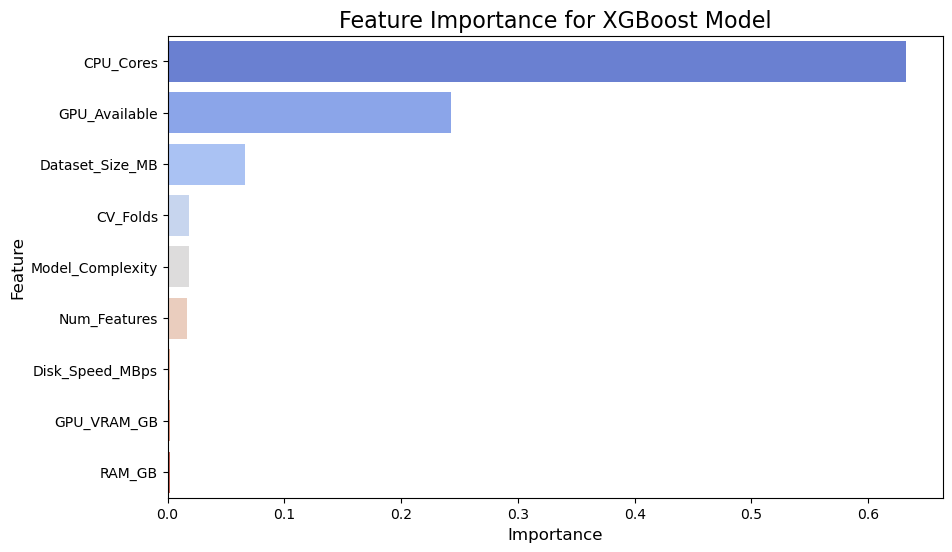

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='coolwarm', hue='Feature')
plt.title('Feature Importance for XGBoost Model', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

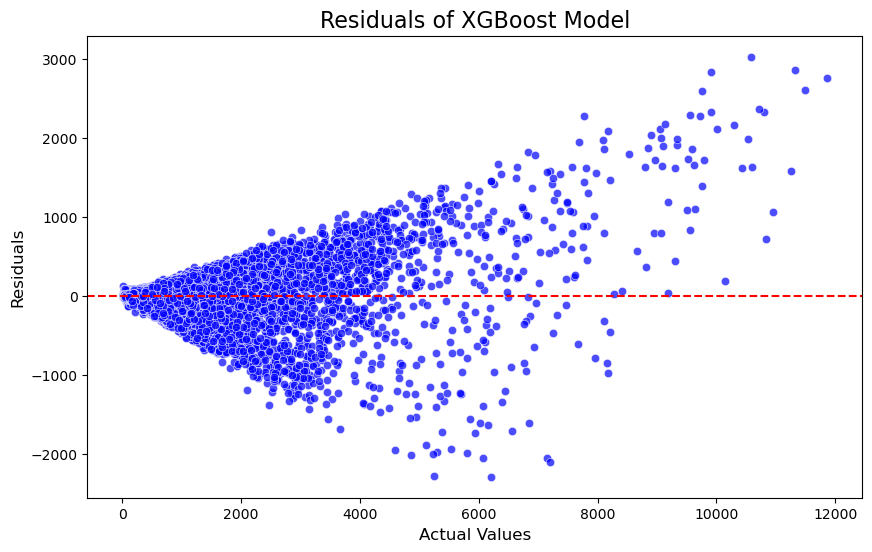

In [19]:
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)  # Reference line
plt.title('Residuals of XGBoost Model', fontsize=16)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

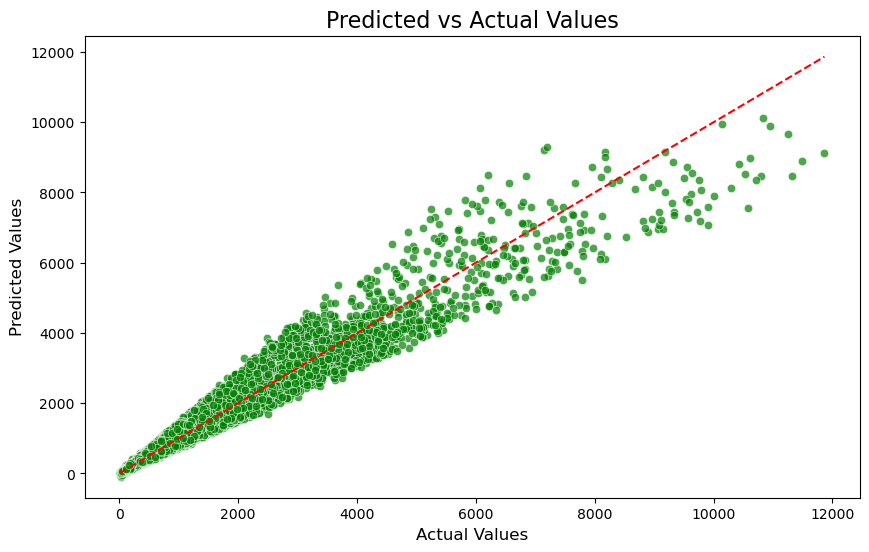

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, color='green')
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=1.5)
plt.title('Predicted vs Actual Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.show()

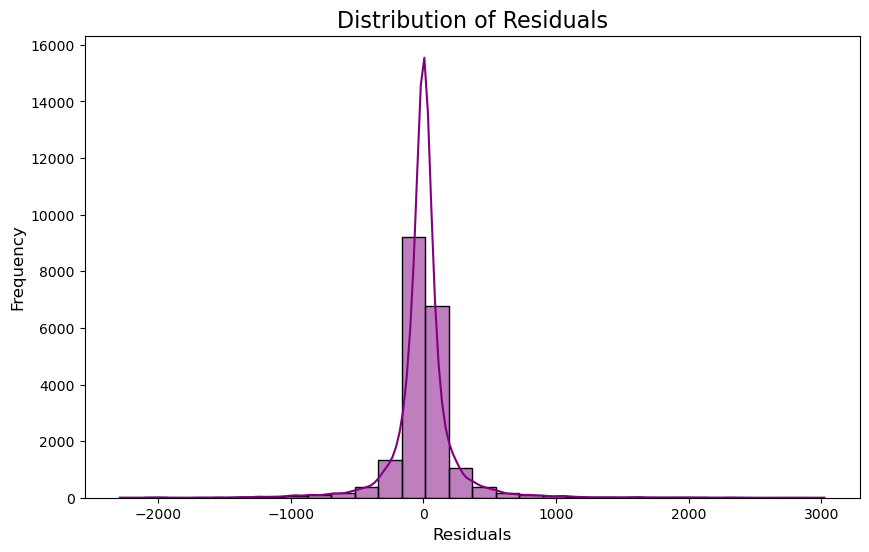

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [22]:
import pickle

with open('models/xgboost_best_model.pkl','wb') as file:
    pickle.dump(best_xgb, file)

print("Model saved as xgboost_best_model.pkl")

Model saved as xgboost_best_model.pkl


In [23]:
with open('models/xgboost_best_model.pkl','rb') as file:
    loaded_model = pickle.load(file)

y_test_pred = loaded_model.predict(X_test)

print("Model loaded and predictions make!")

Model loaded and predictions make!


In [24]:
import numpy as np

# Define the input data
input_data = np.array([
    8,                   # CPU Cores
    16.0,                # RAM (GB)
    0,                   # GPU Available
    0,                   # GPU VRAM (GB)
    326847.38671875,     # Disk Speed (MBps)
    0.06852340698242188, # Dataset Size (MB)
    150,                  # Number of Features
    124,                 # Model Complexity
    5                    # Cross-Validation Folds
]).reshape(1, -1)

In [25]:
# Predict using the LightGBM model
prediction = loaded_model.predict(input_data)
print(f"Prediction: {prediction[0]}")

Prediction: 360.2592468261719


In [26]:
# Convert to minutes if the target is in seconds
prediction_in_seconds = prediction[0]
prediction_in_minutes = prediction_in_seconds / 60

print(f"Prediction in seconds: {prediction_in_seconds:.2f}")
print(f"Prediction in minutes: {prediction_in_minutes:.2f}")

Prediction in seconds: 360.26
Prediction in minutes: 6.00


In [27]:
input_data = np.array([
    8,                   # CPU Cores
    16.0,                # RAM (GB)
    0,                   # GPU Available
    0,                   # GPU VRAM (GB)
    327366.6953125,      # Disk Speed (MBps)
    7.21838474273682,   # Dataset Size (MB)
    24,                  # Number of Features
    6458,                # Model Complexity (updated)
    5                    # Cross-Validation Folds
]).reshape(1, -1)

# Predict using the LightGBM model
prediction = loaded_model.predict(input_data)
print(f"Prediction: {prediction[0]}")

# Convert to minutes if the target is in seconds
prediction_in_seconds = prediction[0]
prediction_in_minutes = prediction_in_seconds / 60

print(f"Prediction in seconds: {prediction_in_seconds:.2f}")
print(f"Prediction in minutes: {prediction_in_minutes:.2f}")

Prediction: 451.22637939453125
Prediction in seconds: 451.23
Prediction in minutes: 7.52


In [28]:
# Define the input data
input_data = np.array([
    8,                   # CPU Cores
    16.0,                # RAM (GB)
    0,                   # GPU Available
    0,                   # GPU VRAM (GB)
    326847.38671875,     # Disk Speed (MBps)
    0.06852340698242188, # Dataset Size (MB)
    24,                  # Number of Features
    134,                 # Model Complexity
    5                    # Cross-Validation Folds
]).reshape(1, -1)

# Predict using the LightGBM model
prediction = loaded_model.predict(input_data)
print(f"Prediction: {prediction[0]}")

# Convert to minutes if the target is in seconds
prediction_in_seconds = prediction[0]
prediction_in_minutes = prediction_in_seconds / 60

print(f"Prediction in seconds: {prediction_in_seconds:.2f}")
print(f"Prediction in minutes: {prediction_in_minutes:.2f}")

Prediction: 357.99951171875
Prediction in seconds: 358.00
Prediction in minutes: 5.97


In [29]:
# Define the input data
input_data = np.array([
    8,                   # CPU Cores
    16.0,                # RAM (GB)
    0,                   # GPU Available
    0,                   # GPU VRAM (GB)
    326847.38671875,     # Disk Speed (MBps)
    0.06852340698242188, # Dataset Size (MB) (approximation for 874 rows)
    230,                 # Number of Features
    215,                 # Model Complexity (adjusted for 215 fits per stack)
    5                    # Cross-Validation Folds
]).reshape(1, -1)

# Predict using the LightGBM model
prediction = loaded_model.predict(input_data)
print(f"Prediction: {prediction[0]}")

# Convert to minutes if the target is in seconds
prediction_in_seconds = prediction[0]
prediction_in_minutes = prediction_in_seconds / 60

print(f"Prediction in seconds: {prediction_in_seconds:.2f}")
print(f"Prediction in minutes: {prediction_in_minutes:.2f}")

Prediction: 476.2079772949219
Prediction in seconds: 476.21
Prediction in minutes: 7.94
